In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import os
import scipy.io as sio
import numpy.linalg as la
from tqdm import tqdm
from scipy.special import hermite
from scipy.special import factorial 
from koopman_pseudospec_qr import KoopPseudoSpecQR
from hankel_dmd_utils import hankel_dmd

# torch.cuda.get_device_name()

In [2]:
file_path = 'data_pendulum_90.mat'
# file_path = 'data_pendulum_240.mat'
data_pendulum = loadmat(file_path)

In [3]:
# Assuming the loaded MAT-file is named data_pendulum_90
X = data_pendulum['DATA_X']
Y = data_pendulum['DATA_Y']

print(X.shape)

(90000, 2)


In [4]:
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]


In [5]:
def hermite_fourier(X, order_hermite=10, order_fourier=15, use_constant = False):
    if X.ndim == 1:
        theta, dtheta = X[0], X[1]
    else:
        theta, dtheta = X[:, 0], X[:, 1]
    basis = []
    start_range= int (not use_constant)
    for kk in arange( start_range, order_fourier + 1):
        for jj in arange (start_range, order_hermite + 1):
            herm = hermite(jj)
           
            C= 2**jj * factorial(jj)
            herm_function = herm(dtheta)*np.exp (- 0.5*dtheta**2) / np.sqrt(C) 
            if (kk>0):
                curr_basis_func1= np.exp(1j * kk * theta)*herm_function
                curr_basis_func2= np.exp(-1j * kk * theta)*herm_function
                curr_basis_func1= curr_basis_func1/la.norm (curr_basis_func1)
                curr_basis_func2= curr_basis_func2/la.norm (curr_basis_func2)
                basis.append(curr_basis_func1)
                basis.append(curr_basis_func2)
            else:
                curr_basis_func1= herm_function
                curr_basis_func1= curr_basis_func1/la.norm (curr_basis_func1)
                basis.append(curr_basis_func1)
    return np.array(basis).T

In [6]:
# def hermite_fourier_real(X, order_hermite=10, order_fourier=15, use_constant= False):
#     if X.ndim == 1:
#         theta, dtheta = X[0], X[1]
#     else:
#         theta, dtheta = X[:, 0], X[:, 1]
#     basis = []
#     start_range= int (not use_constant)
#     for kk in arange( start_range, order_fourier + 1):
#         for jj in arange (start_range, order_hermite + 1):
#             herm = hermite(jj)
#             #C= 2**jj * np.math.factorial(jj)
#             C= 2**jj * factorial(jj)
#             herm_function = herm(dtheta)*np.exp (- 0.5*dtheta**2) / np.sqrt(C) 
#             if (kk>0):
#                 curr_basis_func1= np.sin( kk * theta)*herm_function
#                 curr_basis_func2= np.cos( kk * theta)*herm_function
#                 curr_basis_func1= curr_basis_func1/la.norm (curr_basis_func1)
#                 curr_basis_func2= curr_basis_func2/la.norm (curr_basis_func2)
#                 basis.append(curr_basis_func1)
#                 basis.append(curr_basis_func2)
#             else:
#                 curr_basis_func1= herm_function
#                 curr_basis_func1= curr_basis_func1/la.norm (curr_basis_func1)
#                 basis.append(curr_basis_func1)
#     return np.array(basis).T

In [7]:
#dictionary_func= hermite_fourier
dictionary_func= hermite_fourier

In [8]:
Psi_X = dictionary_func(X)
Psi_Y = dictionary_func(Y)

In [9]:
G= np.matmul (conj (Psi_X.T), Psi_X)

In [10]:
Psi_X.shape

(90000, 300)

In [11]:
def edmd(X, Y, dictionary_func, reg=1e-6):
    PsiX = dictionary_func(X)
    PsiY = dictionary_func(Y)
    
    # Add regularization to improve stability
    K = np.linalg.inv(conj(PsiX).T @ PsiX + reg * np.eye(PsiX.shape[1])) @ (conj(PsiX.T) @ PsiY)
    
    # Compute eigenvalues and eigenvectors of the Koopman operator
    eigenvalues, eigenvectors = la.eig(K)
    
    # Compute eigenfunctions
    eigenfunctions = PsiX @ eigenvectors
    
    return K, eigenvalues, eigenvectors, eigenfunctions

In [12]:
K, eigenvalues, eigenvectors, eigenfunctions = edmd(X, Y, dictionary_func=hermite_fourier)

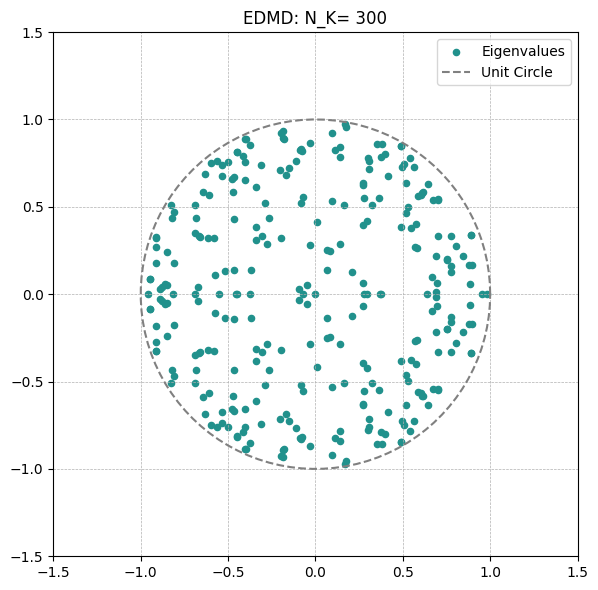

In [13]:
real_parts = eigenvalues.real
imag_parts = eigenvalues.imag

## Plot eigenvalues
plt.figure(figsize=(8, 6), dpi=100)  # Use a square figure size
plt.scatter(real_parts, imag_parts, color=[(33/255, 145/255, 140/255)], label='Eigenvalues', s=20)
# Draw the unit circle
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')
plt.title('EDMD: N_K= ' + str(Psi_X.shape[1]))
# plt.xlabel('Real Part')
# plt.ylabel('Imaginary Part')
# Set the range for x-axis and y-axis
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
# Ensure the aspect ratio is equal
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
# Add extra space to accommodate the legend
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [14]:
m= Psi_X.shape[0]
print (m)
W = np.ones((m, 1), dtype= np.double)

x_pts= arange (-1.5, 1.5+0.05, 0.05)
y_pts=x_pts;
print (x_pts.shape)
x_pts_mesh,y_pts_mesh= meshgrid (x_pts, y_pts)

z_pts= x_pts_mesh + 1j*y_pts_mesh
z_pts= z_pts.ravel()

RES= KoopPseudoSpecQR(Psi_X,Psi_Y,W,z_pts)
RES= RES.reshape (x_pts_mesh.shape)
lower_bound = 1e-16#; % Example lower bound    
#Find indices where the real part of RES is zero
zero_real_indices =nonzero (np.real(RES)==0)    
#% Replace only the real part of RES elements that are zero with the lower bound
RES[zero_real_indices] = lower_bound + imag(RES[zero_real_indices]) * 1j

90000
(61,)


100%|██████████| 3721/3721 [03:32<00:00, 17.54it/s]
C:\Users\xyc93\AppData\Local\Temp\ipykernel_34112\2807378008.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  RES[zero_real_indices] = lower_bound + imag(RES[zero_real_indices]) * 1j


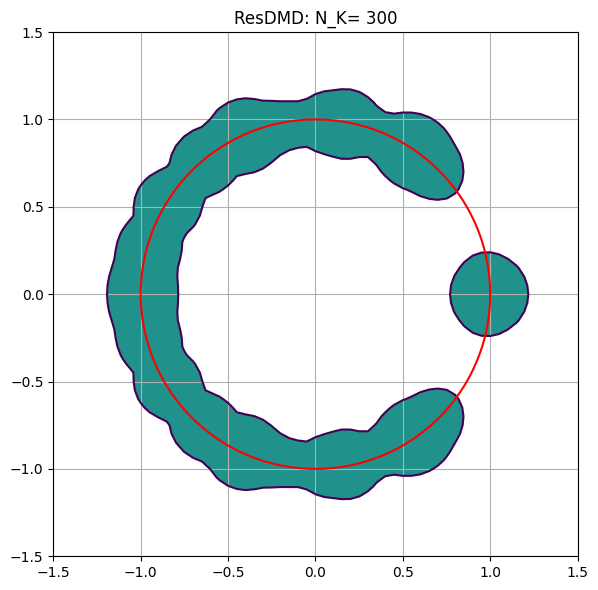

In [15]:
v= array ([0.25, 1e-64])
plt.figure(figsize=(8, 6), dpi=100)
plt.contourf(x_pts_mesh,y_pts_mesh,log10(1/real(RES)),levels= log10(1/v))
plt.contour(x_pts_mesh,y_pts_mesh,log10(1/real(RES)),levels= log10(1/v))
circle_phi= arange (0, 2*np.pi ,2*np.pi/1000 )
plt.plot (np.cos(circle_phi), np.sin(circle_phi), color= 'red')
plt.title ('ResDMD: N_K= '+ str(Psi_X.shape[1]))
plt.grid()
# Add extra space to accommodate the legend
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [16]:
num_traj= 90 #number of trajectories
traj_len = 1000 # length of each trajectory 
window= 851 #chosen to have 300 basis
#number of time delays will be 150
#basis size= number of observables x number of delays
thresh = 13.0 #threshold (in decimal logarithmic units)

In [17]:
eigenvalues, kvecs, K = hankel_dmd(X, n_traj= num_traj, traj_len= traj_len , window=window, thrshhld= thresh)

100%|██████████| 90/90 [00:00<00:00, 1144.52it/s]


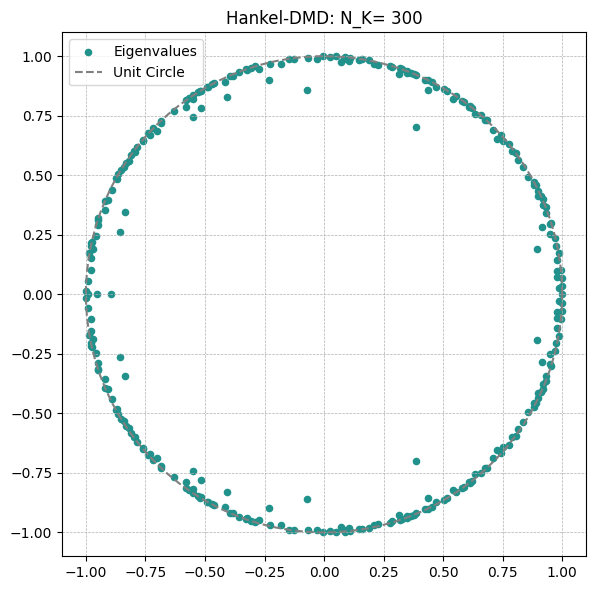

In [18]:
real_parts = eigenvalues.real
imag_parts = eigenvalues.imag

# Create the plot
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(real_parts, imag_parts, color=[(33/255, 145/255, 140/255)], label='Eigenvalues', s= 20)
# Draw a unit circle for reference
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')
plt.title("Hankel-DMD: N_K= " +str (eigenvalues.shape[0]), fontsize= 12)
# plt.xlabel('Real Part')
# plt.ylabel('Imaginary Part')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc= 'upper left', fontsize= 10)
# Add extra space to accommodate the legend
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [19]:
num_neurons = 300
device= 'cuda'
checkpoint_file= 'koopman_example_pend_ckpt002.torch'
from solver_edmd_torch import KoopmanNNTorch, KoopmanSolverTorch
basis_function = KoopmanNNTorch(input_size= 2, layer_sizes=[num_neurons,num_neurons,num_neurons], n_psi_train=num_neurons-3).to(device)

solver = KoopmanSolverTorch(dic=basis_function,
                         target_dim=np.shape(data_x_train)[-1],
                         reg=0.1, checkpoint_file= checkpoint_file)

torch.cuda.get_device_name()

solver.build(data_train=data_train,
             data_valid=data_valid,
             epochs=16,
             batch_size=256,
             lr=1e-4,
             log_interval=10,
             lr_decay_factor=.8)

Outer Epoch 1/16
Epoch: 1 	Training Loss: 105.162799 val loss: 41.816594
saving, val loss enhanced: 41.81659350663264 10000
Epoch: 2 	Training Loss: 47.490775 val loss: 55.874595
Epoch: 3 	Training Loss: 49.076793 val loss: 90.521355
Epoch: 4 	Training Loss: 57.054834 val loss: 55.888359
Epoch 1 time: 13.32 seconds
Outer Epoch 2/16
Epoch: 1 	Training Loss: 271.452783 val loss: 35.774561
saving, val loss enhanced: 35.77456101529017 41.81659350663264
Epoch: 2 	Training Loss: 30.869001 val loss: 57.495209
Epoch: 3 	Training Loss: 52.164937 val loss: 63.020836
Epoch: 4 	Training Loss: 62.350428 val loss: 84.440688
Epoch 2 time: 13.39 seconds
Outer Epoch 3/16
Epoch: 1 	Training Loss: 515.960433 val loss: 193.432696
Epoch: 2 	Training Loss: 181.557900 val loss: 226.366824
Epoch: 3 	Training Loss: 200.242488 val loss: 480.595547
Epoch: 4 	Training Loss: 318.086129 val loss: 214.402714
Epoch 3 time: 13.12 seconds
Outer Epoch 4/16
Epoch: 1 	Training Loss: 395.665637 val loss: 91.482355
Epoch: 2

In [20]:
# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver.get_Psi_X().detach().cpu().numpy()
Psi_Y = solver.get_Psi_Y().detach().cpu().numpy()
Koopman_matrix_K = solver.K.detach().cpu().numpy()

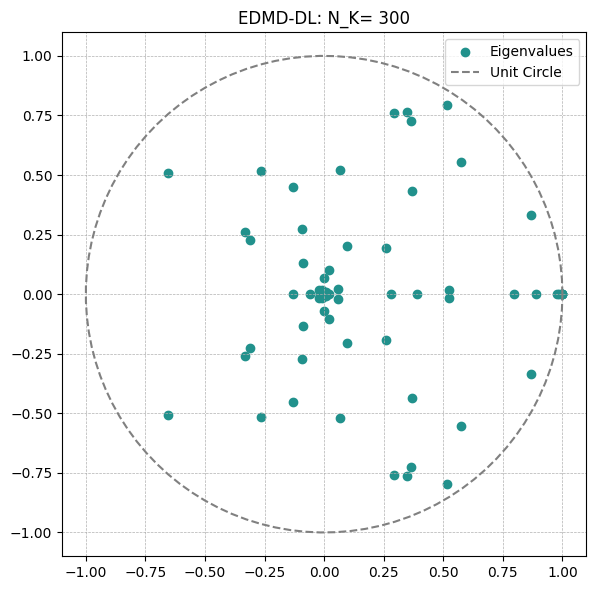

In [21]:
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(real_parts, imag_parts, color=[(33/255, 145/255, 140/255)], label='Eigenvalues')
# Draw a unit circle for reference
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')
plt.title('EDMD-DL: N_K= ' + str(evalues.shape[0]))
# plt.xlabel('Real Part')
# plt.ylabel('Imaginary Part')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
# Add extra space to accommodate the legend
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()